Uma empresa automobilística tem planos de entrar em novos mercados com seus produtos existentes (P1, P2, P3, P4 e P5). Após intensa pesquisa de mercado, eles deduziram que o comportamento do novo mercado é semelhante ao mercado existente.

Em seu mercado existente, a equipe de vendas classificou todos os clientes em 4 segmentos (A, B, C, D). Em seguida, eles realizaram alcance e comunicação segmentados para um segmento diferente de clientes. Esta estratégia tem funcionado e excepcionalmente bem para eles. Eles planejam usar a mesma estratégia para os novos mercados e identificaram 2.627 novos clientes em potencial.

Você deve ajudar o gerente a prever o grupo certo de novos clientes.

In [85]:
#imports basicos
import pandas as pd
import numpy as np
import plotly.express as px
import warnings

#analise exploratoria
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

#preprocessamento
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, RobustScaler, MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

#SVM
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

#avaliação do modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#métodos de avaliação avançados
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.calibration import calibration_curve

In [86]:
#warnings
warnings.filterwarnings("ignore")

## IMPORTANDO ARQUIVO

In [87]:
client = pd.read_csv(r'customer.csv')
client.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,A


In [88]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 919.2+ KB


In [89]:
client.describe()

,ID,Age,Work_Experience,Family_Size
count,10695.000000,10695.000000,9597.000000,10247.000000
mean,463468.088640,43.511828,2.619777,2.844052
std,2600.966411,16.774158,3.390790,1.536427
min,458982.000000,18.000000,0.000000,1.000000
25%,461220.500000,30.000000,0.000000,2.000000
50%,463451.000000,41.000000,1.000000,3.000000
75%,465733.500000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


## ANÁLISE EXPLORATÓRIA

primeiramente vamos analisar a distribuição das variáveis categóricas

In [90]:
#labels para o grafico de barras
def annotate_bars(ax):
    """Add a label on top of each bar in ax."""
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.4,
                '{:d}'.format(int(height)), 
                ha="center") 

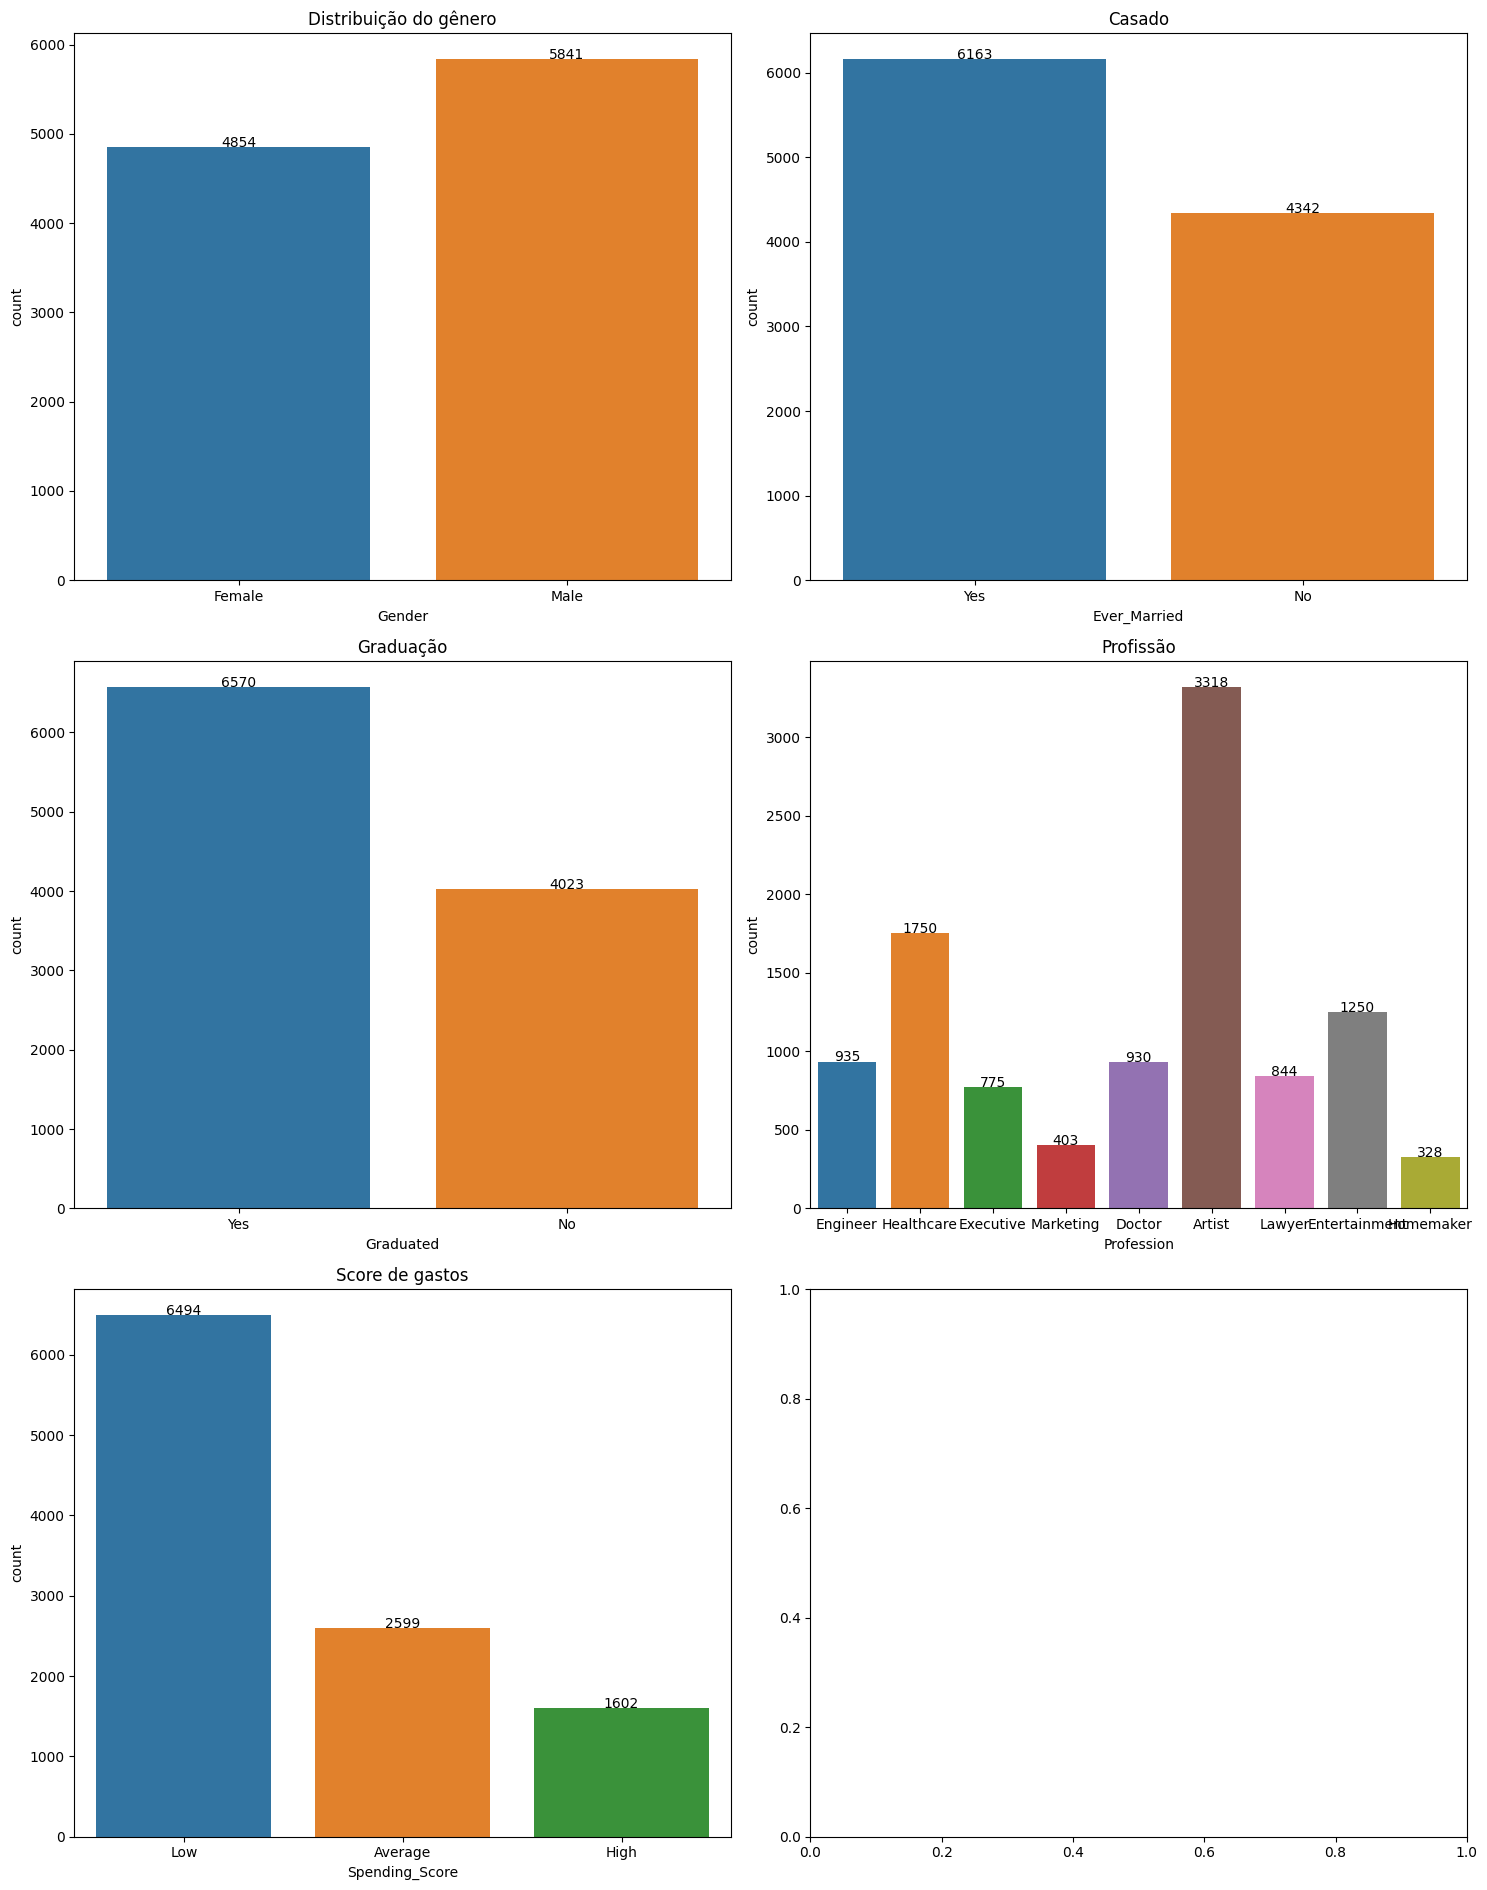

In [91]:
#barplot de contagem das variáveis categóricas
fig, axs = plt.subplots(3, 2, figsize=(15, 19))

#Lista de features e seus títulos
features = [
    ('Gender', 'Distribuição do gênero'),
    ('Ever_Married', 'Casado'),
    ('Graduated', 'Graduação'),
    ('Profession', 'Profissão'),
    ('Spending_Score', 'Score de gastos')
]

# Loop pelas features e plot
for idx, (feature, title) in enumerate(features):
    ax = sns.countplot(data=client, x=feature, ax=axs[idx//2, idx%2])
    ax.set_title(title)
    annotate_bars(ax)

plt.tight_layout()
plt.show()



Conclusões obtidas:
Temos mais mulheres do que homens nesse dataset, assim como maioria dos clientes são casados e a maioria possui graduação. A maioria dos clientes possui como profissão artistas, seguidos com o pessoal da saúde e do entretenimento. E a maioria dos clientes possui baixo score de compras.

Agora vamos partir para análise entre algumas variáveis:

In [92]:

#Lista de features e seus respectivos títulos
bivariate_features = [
    ('Spending_Score', 'Age', 'Age vs Spending_Score','Magenta'),
    ('Profession', 'Age', 'Profession vs Age','Plasma'),
    ('Graduated', 'Work_Experience', 'Graduated vs Work_Experience','Inferno'),
    ('Ever_Married', 'Family_Size', 'Ever_Married vs Family_Size','Cividis')
]

#Lista vazia para adicionar os plots
plots = []

#Criando os plots
for x, y, title, color_sequence in bivariate_features:
    fig = px.box(client, x=x, y=y, title=title, color=x, color_discrete_sequence=px.colors.sequential.__getattribute__(color_sequence))
    plots.append(fig)

#Mostrando os plots
for fig in plots:
    fig.show()

Análises obtidas:
Quanto maior a idade, maior o score dos gastos. Como visto no gráfico, a mediana de cada categoria aumenta aproximadamente 10 anos em relação a anterior, começando da primeira que é de 37 anos. Sobre as profissões, temos que profissionais da saúde tendem a ser mais jovens enquanto que advogados e executivos tendem a possuir mais idade. Artistas e profissionais do entretenimento possuem um range de idades grande. Aqueles que graduaram possuem um maior range de experiencia de trabalho, porém a mediana de experiencia é menor do que os que não trabalharam, podendo ser um sinal de que quem não se graduou começou a trabalhar antes. E finalmente aqueles que casaram tendem a formar famílias maiores. 

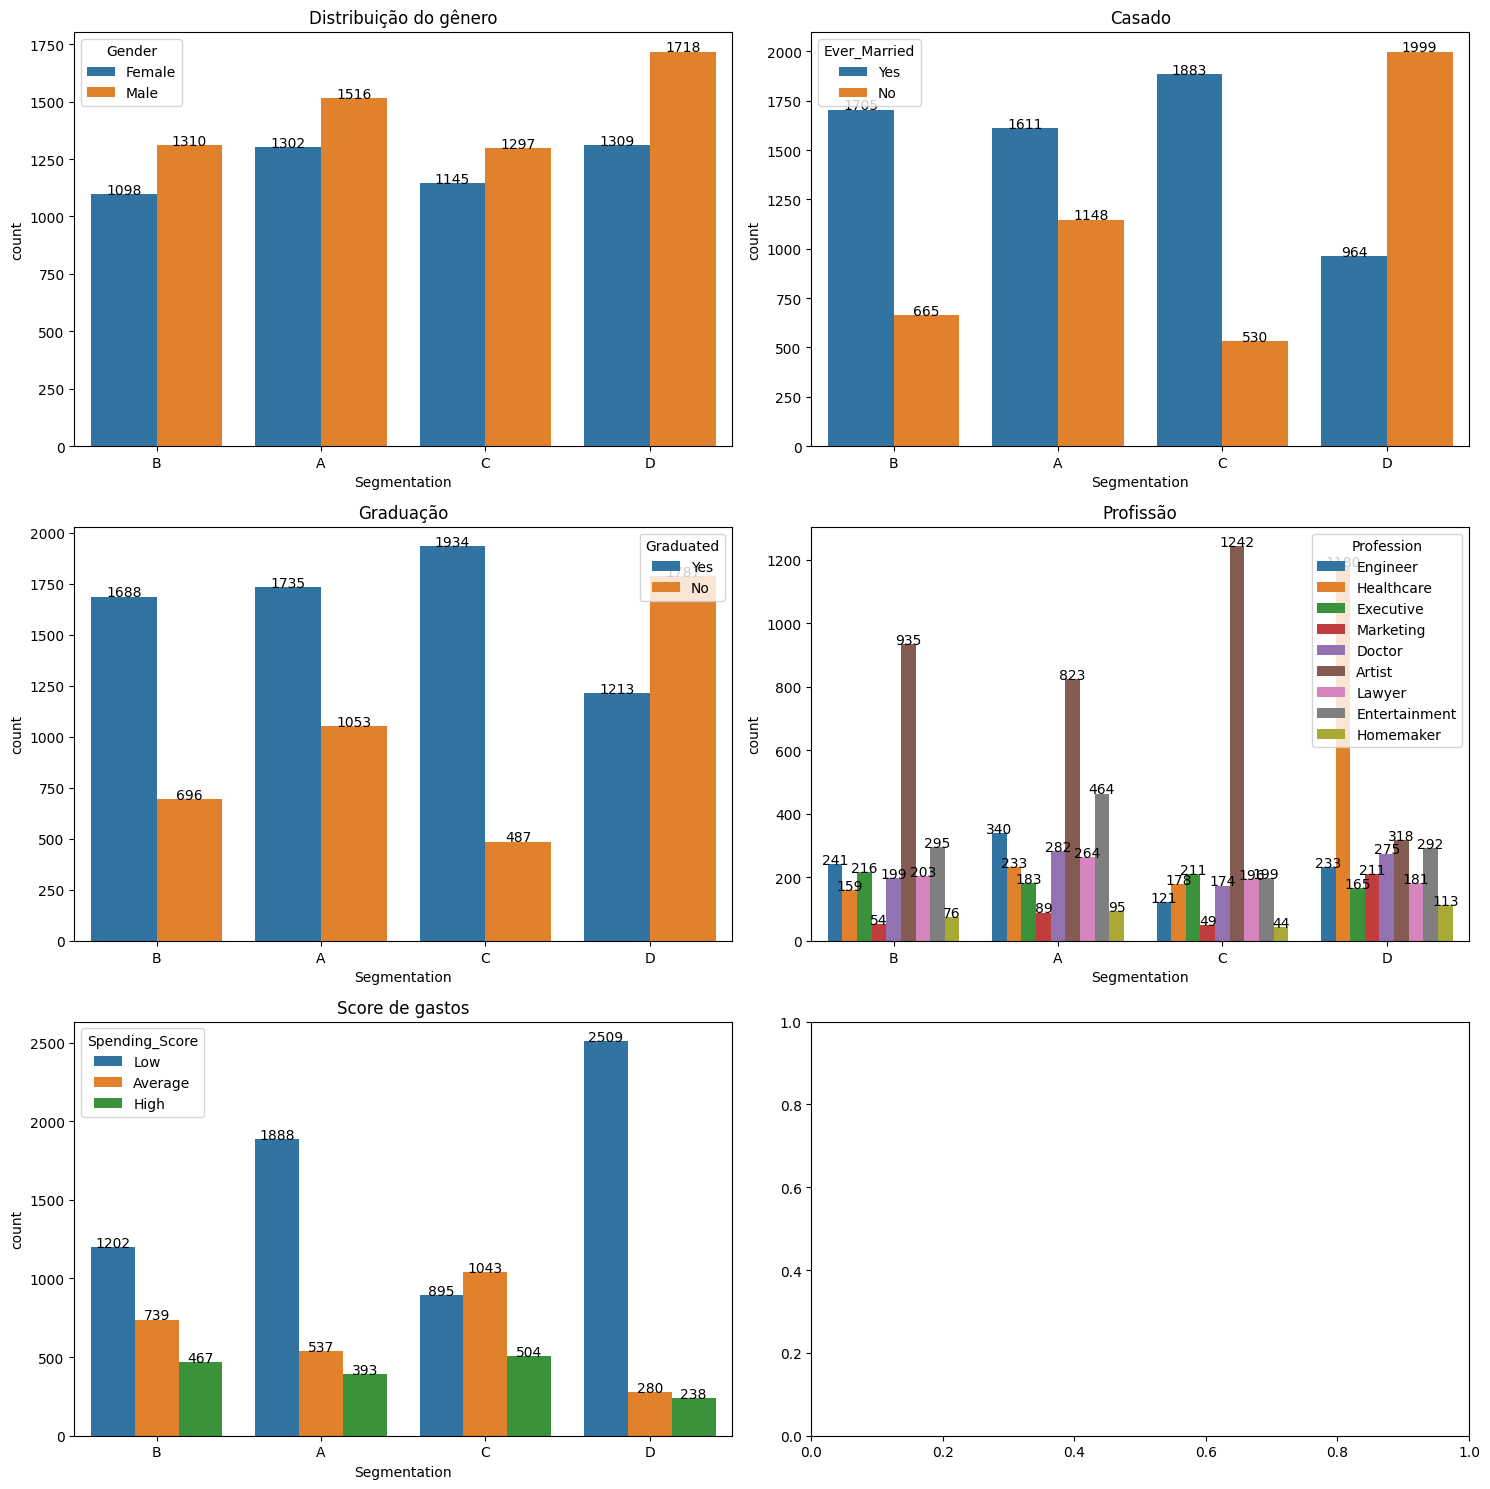

In [93]:
#Setando a figura e os subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

#Lista de features e seus respectivos títulos
segmentation_features = [
    ('Gender', 'Distribuição de gênero por segmentação'),
    ('Ever_Married', 'Estado civil por segmentação'),
    ('Graduated', 'Distribuição de graduação por segmentação'),
    ('Spending_Score', 'Distribuição do score de gastos por segmentação'),
    ('Profession', 'Distribuição da profissão por segmentação')
]

# Loop pelas features e plot
for idx, (feature, title) in enumerate(features):
    ax = sns.countplot(data=client, x='Segmentation', hue=feature, ax=axs[idx//2, idx%2])
    ax.set_title(title)
    annotate_bars(ax)

plt.tight_layout()
plt.show()

Pela análise de nosso target, segmentation, podemos ver que diferentes segmentos representam diferentes características demográficas e comportamentais dos consumidores. Por exemplo, o segmento D pode representar indivíduos mais jovens que estão começando a iniciar suas carreiras, como indicado pela maior proporção de profissionais de saúde, consumidores que não se casaram e consumidores com baixo score de gastos.

In [94]:
# Criando a figura subplots
fig = make_subplots(rows=1, cols=2)

#Criando os histogramas
hist_work_experience = px.histogram(client, x='Work_Experience')
hist_family_size = px.histogram(client, x='Family_Size')

#Extraindo os tracers
fig.add_trace(hist_work_experience.data[0], row=1, col=1)
fig.add_trace(hist_family_size.data[0], row=1, col=2)

#Mostrando a figura
fig.show()

Com os histogramas acima vemos a distribuição das duas variáveis numéricas


## SPLIT DOS DADOS

In [95]:
client.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,A


In [96]:
client[['Ever_Married','Graduated']] = client[['Ever_Married','Graduated']].fillna(method="ffill")

In [97]:
#como a coluna ID não é relevante para nosso modelo, vamos remover ela
client.drop('ID', axis=1, inplace=True)

In [98]:
#vamos trocar o nome da coluna Var_1
client.rename(columns= {'Var_1':'Category'}, inplace=True)

Agora será feito o split dos dados de modo a evitar data leakage:

In [99]:
#criando os dataframes X e y
X = client.drop('Segmentation', axis=1)
y = client['Segmentation']

In [100]:
X.shape

(10695, 9)

In [101]:
y.shape

(10695,)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

## FEATURE ENGINEERING

In [103]:
X_train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Category
2980,Female,No,29,No,Healthcare,1.0,Low,3.0,Cat_6
7756,Male,Yes,48,No,Entertainment,5.0,Average,2.0,Cat_2
8006,Male,Yes,70,Yes,Entertainment,8.0,Average,2.0,Cat_6
1564,Female,Yes,56,Yes,Artist,1.0,Average,5.0,Cat_6
6386,Male,No,37,Yes,Entertainment,7.0,Low,1.0,Cat_6


primeiramente iremos lidar com valores nulos

In [104]:
colunas = X_train.columns

for col in colunas:
    a = X_train[col].isnull().sum()
    print(f"Column: {col}, Null Count: {a}")

Column: Gender, Null Count: 0
Column: Ever_Married, Null Count: 0
Column: Age, Null Count: 0
Column: Graduated, Null Count: 0
Column: Profession, Null Count: 123
Column: Work_Experience, Null Count: 822
Column: Spending_Score, Null Count: 0
Column: Family_Size, Null Count: 342
Column: Category, Null Count: 83


agora criaremos outro transformer para as variáveis numéricas

In [105]:
class CustomNumericalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, var1, var2):
        self.var1 = var1  # First numerical variable
        self.var2 = var2  # Second numerical variable
        self.median1 = None
        self.median2 = None

    def fit(self, X, y=None):
        # Ensure X is a DataFrame
        X = pd.DataFrame(X, columns=[self.var1, self.var2])

        # Compute the median for each variable
        self.median1 = X[self.var1].median()
        self.median2 = X[self.var2].median()
        return self

    def transform(self, X):
        # Ensure X is a DataFrame
        X = pd.DataFrame(X, columns=[self.var1, self.var2])

        # Impute the median to NaNs for each variable and return
        X[self.var1].fillna(self.median1, inplace=True)
        X[self.var2].fillna(self.median2, inplace=True)
        return X


In [106]:
#instanciando
numerical_imputer = CustomNumericalImputer('Work_Experience', 'Family_Size')

agora vamos começar a remoção das strings. Primeiramente das colunas com categorias binárias, onde será feito Yes = 1 e No = 0

In [107]:
class YesNoTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col] = X[col].map({'Yes': 1, 'No': 0})
        return X_transformed

faremos o mesmo para a coluna gender

In [108]:
class MaleFemaleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col] = X[col].map({'Male': 1, 'Female': 0})
        return X_transformed

E finalmente as outras colunas com strings usaremos o one hot encode

E com isso temos o nosso column transformer para aplicar nos dados de treino e teste:

In [109]:
preprocessor = ColumnTransformer(
    transformers=[
        ('Remoção dos nulos das colunas numéricas', numerical_imputer, ['Work_Experience', 'Family_Size','Age']),
        ('Remoção Yes/No', YesNoTransformer(), ['Ever_Married','Graduated']),
        ('Remoçao male/female',MaleFemaleTransformer(),['Gender']),
        ('One hot encode', OneHotEncoder(drop='first'),['Profession','Spending_Score','Category'])
    ],
    remainder='passthrough'
)

aplicando as transformações nos dados de treino e teste:

In [110]:
X_traint = preprocessor.fit_transform(X_train)

In [111]:
X_testt = preprocessor.fit_transform(X_test)

In [112]:
X_traint.shape

(8021, 23)

In [113]:
y_train.shape

(8021,)

In [114]:
X_testt.shape

(2674, 23)

In [115]:
y_test.shape

(2674,)

In [116]:
pd.DataFrame(X_traint)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,5.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8016,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8017,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8018,8.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8019,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## MODELAGEM

In [117]:
#instanciando SVC
svc = SVC()

#instanciando one vs one, pois temos um target multiclass
ovso = OneVsOneClassifier(svc)

#treinando
ovso.fit(X_traint, y_train)

OneVsOneClassifier(estimator=SVC())

In [118]:
#fazendo a predição dos dados
y_pred = ovso.predict(X_testt)

In [119]:
#acurácia
print('Acurácia da regressão logística nos dados de teste: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Acurácia da regressão logística nos dados de teste: 0.47


agora será feita a matriz de confusão:

Text(0.5, 427.9555555555555, 'Predicted label')

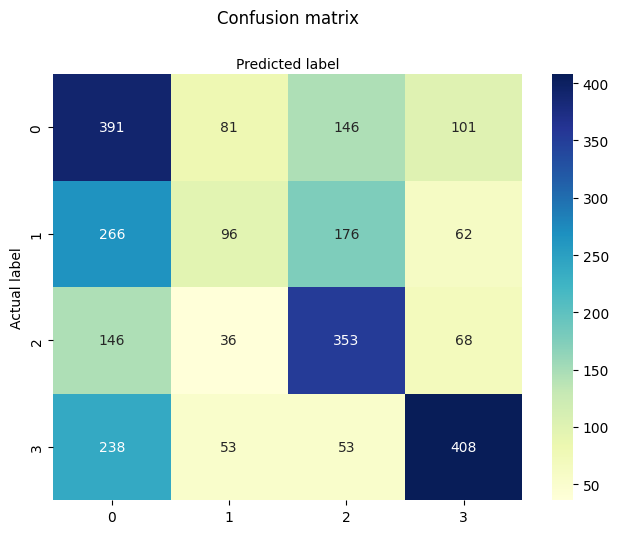

In [120]:
cnf_matrix = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [121]:
target_names = ['A', 'B','C','D']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           A       0.38      0.54      0.44       719
           B       0.36      0.16      0.22       600
           C       0.48      0.59      0.53       603
           D       0.64      0.54      0.59       752

    accuracy                           0.47      2674
   macro avg       0.46      0.46      0.45      2674
weighted avg       0.47      0.47      0.45      2674



como vimos acima, obtivemos resultados bem ruins, e por isso deveremos fazer um grid search para melhorar isso

## MELHORANDO O MODELO

In [122]:
#faremos um grid search para encontrar os melhores parâmetros para o modelo
parameters_dictionary = {'kernel':['linear', 'rbf','sigmoid'], 
                         'C':[0.0001, 0.1, 1, 10], 
                         'gamma': [1, 10, 50, 100]
                         }

svc = SVC()

grid_search = GridSearchCV(svc, 
                           parameters_dictionary, 
                           scoring = 'accuracy',
                           return_train_score=True, 
                           cv = 5,
                           verbose = 1,
                           n_jobs=-1) 

grid_search.fit(X_traint, y_train)

best_model = grid_search.best_estimator_
best_parameters = grid_search.best_params_
best_f1 = grid_search.best_score_

print('The best model was:', best_model)
print('The best parameter values were:', best_parameters)
print('The best f1-score was:', best_f1)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
The best model was: SVC(C=10, gamma=1, kernel='linear')
The best parameter values were: {'C': 10, 'gamma': 1, 'kernel': 'linear'}
The best f1-score was: 0.43186768281787746


## AVALIAÇÃO DO MODELO

de acordo com o crossvalidation acima os resultados não foram satisfatórios. Provavelmente usar outro algoritmo para este dataset melhoraria os resultados, porém ainda assim será feito testes de avaliação dos parâmetros

In [154]:
svm = SVC(C=10, kernel='linear', gamma=1)
svm_model = OneVsOneClassifier(svm)

#treinando
svm_model.fit(X_traint, y_train)

OneVsOneClassifier(estimator=SVC(C=10, gamma=1, kernel='linear'))

In [155]:
#fazendo a predição dos dados
y_predf = svm_model.predict(X_testt)

In [156]:
#acurácia
print('Acurácia da regressão logística nos dados de teste: {:.2f}'.format(accuracy_score(y_test, y_predf)))

Acurácia da regressão logística nos dados de teste: 0.45


Text(0.5, 427.9555555555555, 'Predicted label')

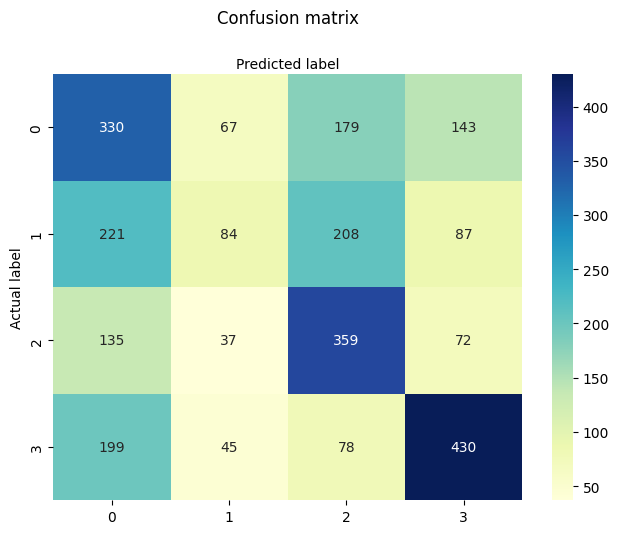

In [157]:
#matriz de confusão
cnf_matrix = confusion_matrix(y_test, y_predf)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [153]:
target_names = ['A', 'B','C','D']
print(classification_report(y_test, y_predf, target_names=target_names))

              precision    recall  f1-score   support

           A       0.37      0.46      0.41       719
           B       0.36      0.14      0.20       600
           C       0.44      0.60      0.50       603
           D       0.59      0.57      0.58       752

    accuracy                           0.45      2674
   macro avg       0.44      0.44      0.42      2674
weighted avg       0.44      0.45      0.43      2674

